In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
# >>>>>填写<<<< 利用pandas的load_csv函数，读取我们的train 和 test数据集合 变量已经给出 >>>>>填写<<<< ######
train = pd.read_csv("subset_train.csv")
test = pd.read_csv("Small_test.csv")
#####train validation test(完全独立的，与训练过程无关的)

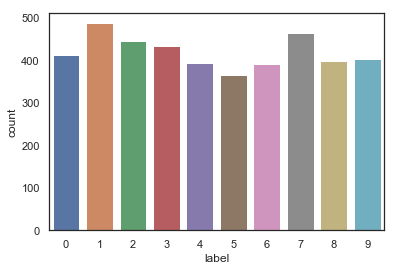

In [3]:
# >>>>>填写<<<< 利用pandas的header选择，将label列传递给Y_train >>>>>填写<<<< 
Y_train = train["label"]
Y_test = test['label']
# 因为train.csv中，第一列label在上述代码已经传递给Y_label，这里对于x_train 我们不需要训练集的第一列 #####
X_train = train.drop(labels = ["label"],axis = 1) 
X_test = test.drop(labels = ["label"],axis = 1)
# 释放内存
g = sns.countplot(Y_train)
Y_train.value_counts()
Y_train
Y_test.value_counts()
g = sns.countplot(Y_train)

## We have similar counts for the 10 digits.

## 2.2 Check for null and missing values

In [4]:
# 检查训练数据是否有空值
X_train.isnull().any().describe() 

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
# >>>>填写<<<< 检查训练数据是否有空值 >>>>填写<<<< ###
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

## 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].
标准化，将灰度值 0-255 映射到0 - 1区间

In [6]:
# Normalize the data
X_train = X_train / 255.0
###### >>>填写<<< 标准化测试集合 #######
X_test = X_test / 255.0

## 2.3 Reshape

In [7]:
# >>>>填写<<<<< 利用 reshape 函数， 将X_train变换成 (height = 28px, width = 28px , canal = 1)>>>>填写<<<<< ######
X_train = X_train.values.reshape(-1,28,28)
X_test = X_test.values.reshape(-1,28,28) 


Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. 

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices. 

## 2.5 Label encoding

In [8]:
# 利用0 1编码 将0-9数字标签编码成10维向量 (ex : 9 -> [0,0,0,0,0,0,0,0,0,1])
##
Y_train = to_categorical(Y_train, num_classes = 10)
Y_test = to_categorical(Y_test, num_classes = 10)
## one-hot encoding

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.6 Split training and valdiation set 

In [9]:
# Set the random seed
random_seed = 2

In [10]:
# 将训练集合按照9:1 分成训练集合 和验证集合 validation 10折交叉验证 10-fold validation  ####
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

We can get a better sense for one of these examples by visualising the image and looking at the label.

In [11]:
# Some examples #x-train里面第一个sample的 0:最大 0:最大 0 [:,:,0] 
#g = plt.imshow(X_train[0][:,:,0],cmap='gray') #plt为什么把灰度可以生

# 3. CNN
## 3.1 Define the model

In [12]:
batch_size = 100
num_classes = 10
epochs = 50
from keras.layers import SimpleRNN
model = Sequential()  
input_shape = (28, 28)
model.add(SimpleRNN(128, input_shape = input_shape, return_sequences=True))           
model.add(Dropout(0.3))           
model.add(SimpleRNN(128))
model.add(Dropout(0.2))

model.add(Dense(10,activation='softmax'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 28, 128)           20096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 128)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 54,282
Trainable params: 54,282
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
history = model.fit(X_train,Y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_val,Y_val),callbacks=[learning_rate_reduction])

Train on 3780 samples, validate on 420 samples
Epoch 1/50
3780/3780 [==============================] - 3s 919us/step - loss: 1.1743 - accuracy: 0.6071 - val_loss: 0.7158 - val_accuracy: 0.7810
Epoch 2/50
3780/3780 [==============================] - 3s 757us/step - loss: 0.6642 - accuracy: 0.7918 - val_loss: 0.7279 - val_accuracy: 0.7857
Epoch 3/50
3780/3780 [==============================] - 2s 603us/step - loss: 0.5135 - accuracy: 0.8426 - val_loss: 0.8294 - val_accuracy: 0.7476
Epoch 4/50
3780/3780 [==============================] - 2s 587us/step - loss: 0.4246 - accuracy: 0.8664 - val_loss: 0.5414 - val_accuracy: 0.8214
Epoch 5/50
3780/3780 [==============================] - 2s 587us/step - loss: 0.3622 - accuracy: 0.8892 - val_loss: 0.5155 - val_accuracy: 0.8429
Epoch 6/50
3780/3780 [==============================] - 2s 585us/step - loss: 0.3266 - accuracy: 0.9040 - val_loss: 0.4208 - val_accuracy: 0.8643
Epoch 7/50
3780/3780 [==============================] - 3s 672us/step - loss:

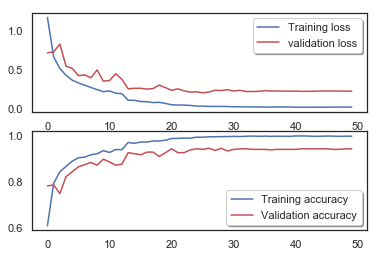

In [16]:
fig, ax = plt.subplots(2,1)

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

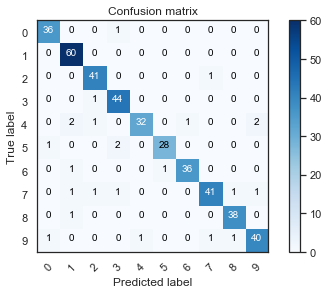

In [17]:
# 生成10标签混淆矩阵

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

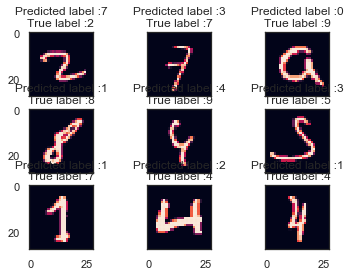

In [18]:
### 打印出认错的数字

errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 9 errors 
most_important_errors = sorted_dela_errors[-9:]

# Show the top 9 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [19]:
#optional 画出roc
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = model.predict(X_test)
# 在前天的作业中 y_test Pandas下的DataFrame类型：y_test
# 让数据为 Pandas DataFrame类型的话 调用/使用他 第i行第j列的数据:
#  y_test.iloc[i,j]

# 在今天的作业中，y_test是 numpy的 numarry数据类型
# 让数据为numarray 类型的话 调用/使用他 第i行第j列的数据:
# y_test[i,j]
for i in range(num_classes):
     fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], y_score[:,i]) #
    # AUC Area Under the Curve
     roc_auc[i] = auc(fpr[i], tpr[i])
#y_pred_keras = model.predict(X_test).ravel()
##fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
#y_pred_keras

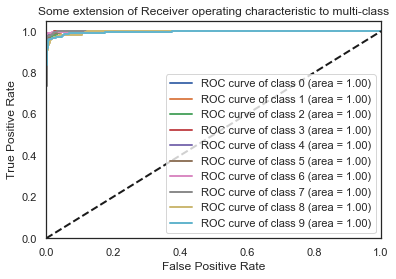

In [20]:
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
    


### 真标签 Y_score
 #   1     .99
 #   1     .98
 #   1     .97
 #   1     .96
 #   1     .98
 #   1     .000000001

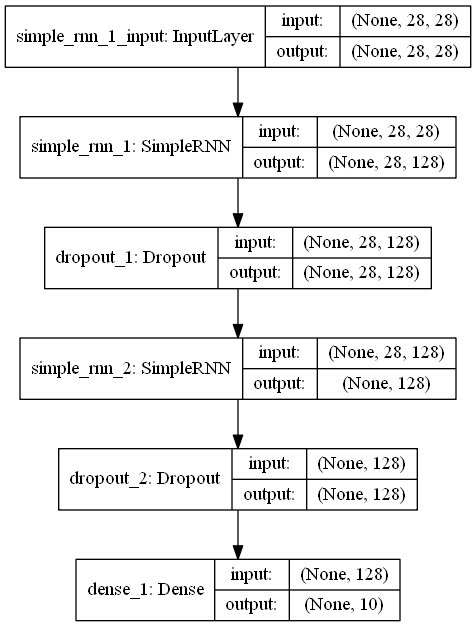

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [22]:
y_score.shape

(2100, 10)